In [2]:
#Import 'Documenting Hate' data from ProPublica
import csv
documenting_hate = []
with open('documenting_hate.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader, None) #skip header
    for row in reader:
        documenting_hate.append({
            'date': row[1].split()[0],
            'title': row[2],
            'organization': row[3],
            'city': row[4],
            'state': row[5],
            'url': row[6],
            'keywords': row[7].split() if row[7] is not None else [],
            'summary': row[7] if row[7] is not None else ""
        })

In [3]:
#Extract keywords from titles, sort articles by source
from rake_nltk import Rake
rake = Rake()
articles_by_source = {}
unique_keywords = {}
for article in documenting_hate:
    if not article['organization'] in articles_by_source.keys():
        articles_by_source[article['organization']] = []
        
    extracted_keywords = rake.extract_keywords_from_text(article['title'])
    if extracted_keywords is not None:
        article['keywords'] = article['keywords'].append(extracted_keywords)
    
    for keyword in article['keywords']:
        if not keyword in unique_keywords:
            unique_keywords[keyword] = 1
        else:
            unique_keywords[keyword] += 1
            
    articles_by_source[article['organization']].append(article)
            
#Filter out sources with < 5 articles
articles_by_source = {k:v for k,v in articles_by_source.items() if len(v) >= 5}

print("News Sources: ", len(articles_by_source.keys()))
print("Unique keywords: ", len(unique_keywords))

News Sources:  174
Unique keywords:  8095


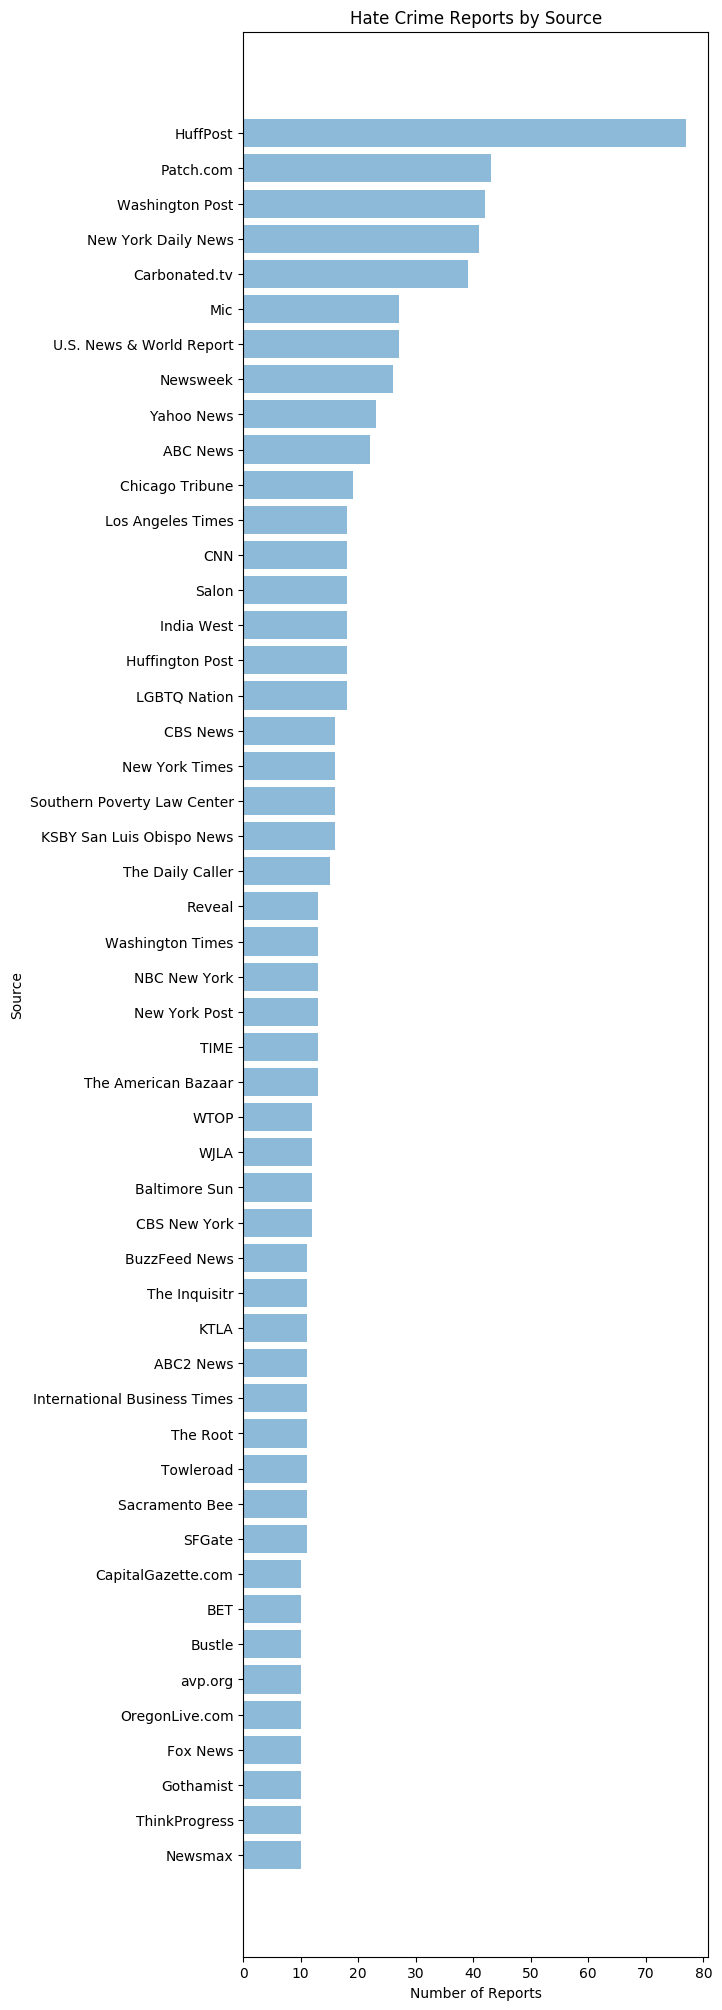

In [4]:
#Sort sources by num. reports, select 50 best
source_num_articles = [(k, len(v)) for k,v in articles_by_source.items()]
source_num_articles = sorted(source_num_articles, key=lambda tup: tup[1])
sources, num_articles = zip(*source_num_articles[len(source_num_articles) - 50:])

#Plot num. articles by source
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


y_pos = np.arange(len(sources))
plt.figure(figsize = (6,25))
plt.barh(y_pos, num_articles, align='center', alpha=0.5)
plt.yticks(y_pos, sources)
plt.xlabel('Number of Reports')
plt.ylabel('Source')
plt.title('Hate Crime Reports by Source')

plt.show()

From the looks of things, there's an overrepresentation of special-interest news outlets and a surprising amount of under-reporting by national news outlets, at least according to the Documenting Hate database.

[[datetime.date(2017, 5, 15)], [datetime.date(2017, 3, 2)], [datetime.date(2017, 5, 31)], [datetime.date(2017, 5, 22)], [datetime.date(2017, 6, 19)]]


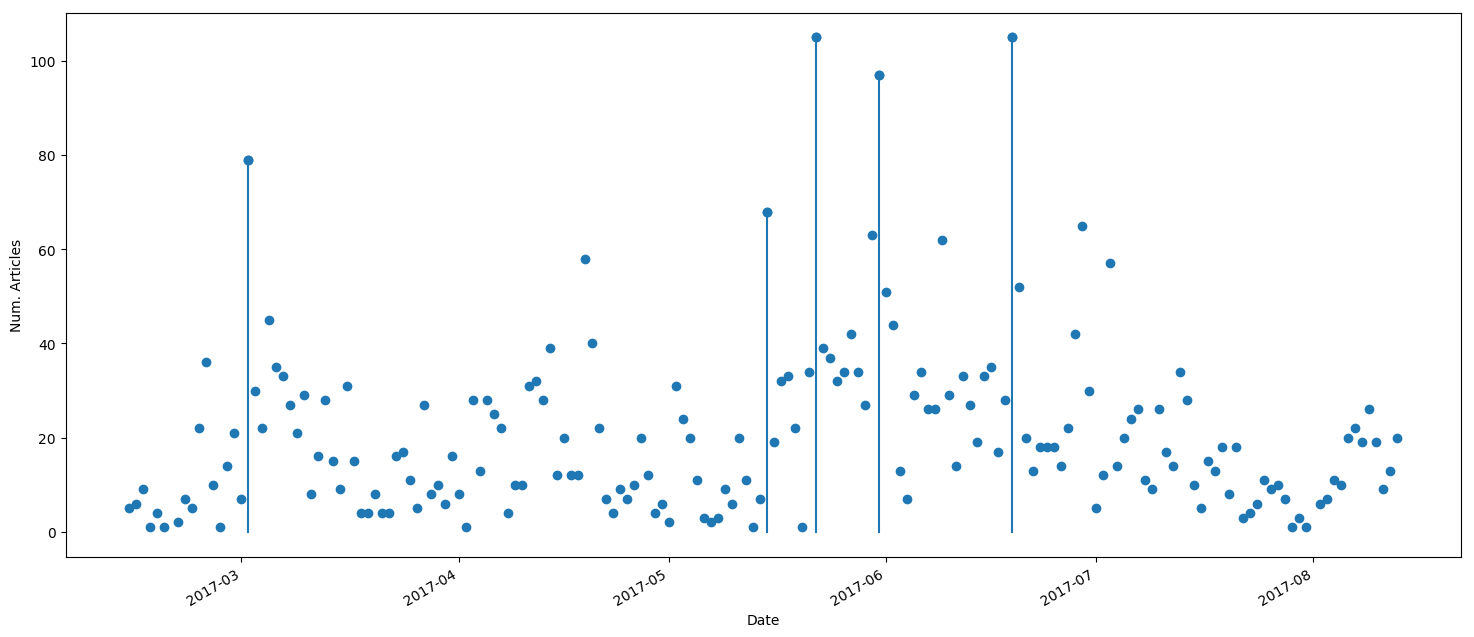

In [43]:
plt.close()

#Get dates of each article
articles_by_date = {}
from datetime import date
for article in documenting_hate:
    month, day, year = article['date'].split()[0].split('/')
    art_date = date(int('20' + year), int(month), int(day))

    if art_date not in articles_by_date.keys():
        articles_by_date[art_date] = 1
    else:
        articles_by_date[art_date] += 1

#Sort by date
from matplotlib.dates import date2num
date_num_articles = [(k,v) for k,v in articles_by_date.items()]
date_num_articles = sorted(date_num_articles, key=lambda tup: tup[0])
orig_dates, num_articles = zip(*date_num_articles)
dates = date2num(orig_dates)

#Fit Gaussian mixture model
# from sklearn.mixture import GaussianMixture
# gauss = GaussianMixture(n_components=3)

# sample = np.random.randint(0, len(dates), int(len(dates)*.2) - 1)

# gauss.fit([[dates[i],num_articles[i]] for i in sample])

#Plot reports over time
plt.figure(figsize=(18,8))
plt.plot_date(dates, num_articles)
plt.gcf().autofmt_xdate()

#Find outliers
outliers = sorted(date_num_articles, key=lambda tup: tup[1])[len(date_num_articles) - 5:]
plt.stem(date2num([o[0] for o in outliers]), [o[1] for o in outliers], basefmt=' ')

plt.xlabel("Date")
plt.ylabel("Num. Articles")

print(list([o[0]] for o in outliers))

plt.show()

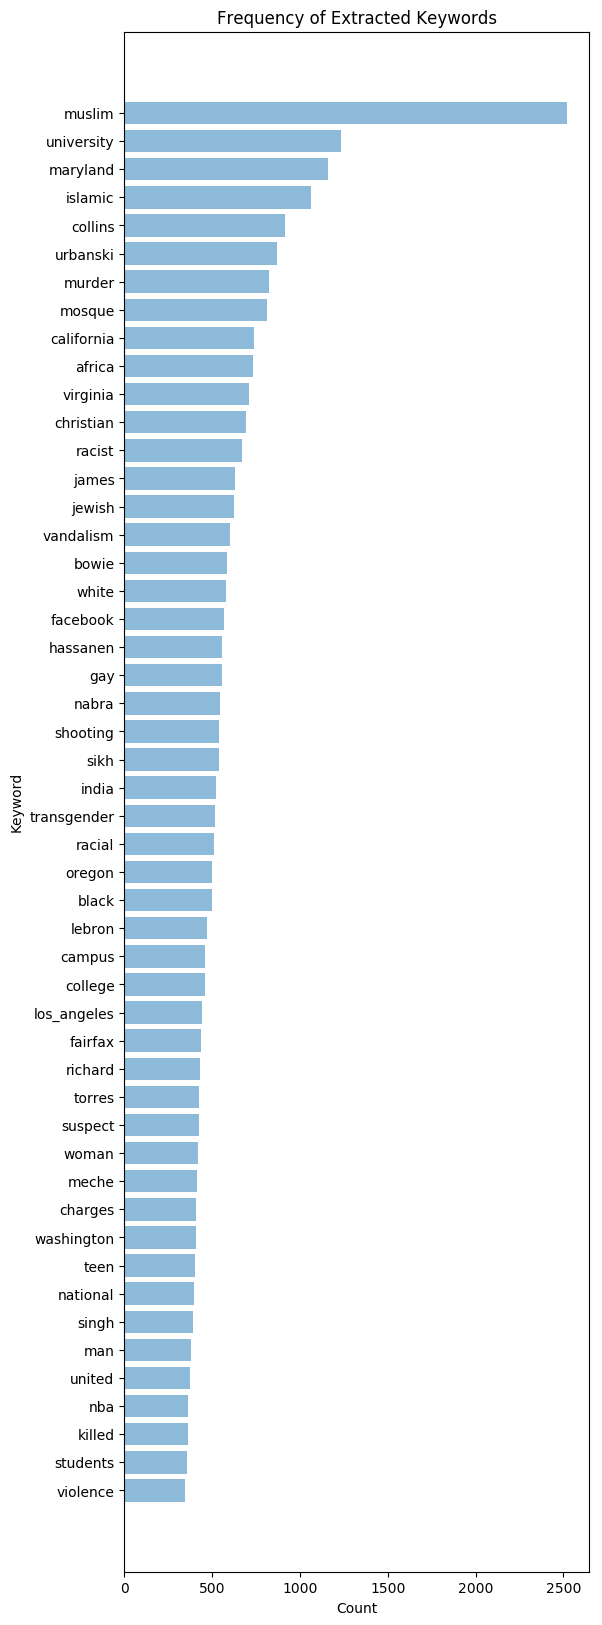

In [50]:
plt.close()

#Remove a pre-designated collection of keywords
REMOVED_KEYWORDS = [
    'hate','police','crime',
    'american','state','fbi','city',
    'attack','anti','president',
    'iii','bias','justice','donald',
    'chief','park','incidents','court',
    'slurs','slur','york','jersey','stabbing',
    'portland','district','attorney','law','victims',
    'nydailynews', 'nydn', 'nydnvideo','twitter',
    'crimes'
]
unique_keywords = {key: unique_keywords[key]
                   for key in unique_keywords.keys()
                   if key not in REMOVED_KEYWORDS}

#Graph frequency of 50 most common keywords
keyword_freq_pairs = [(k, v) for k,v in unique_keywords.items()]
keyword_freq_pairs = sorted(keyword_freq_pairs, key=lambda tup: tup[1])
keyword_labels, keyword_freq = zip(*keyword_freq_pairs[len(keyword_freq_pairs) - 50:])

y_pos = np.arange(len(keyword_labels))
plt.figure(figsize = (6,20))
plt.barh(y_pos, keyword_freq, align='center', alpha=0.5)
plt.yticks(y_pos, keyword_labels)
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.title('Frequency of Extracted Keywords')

plt.show()


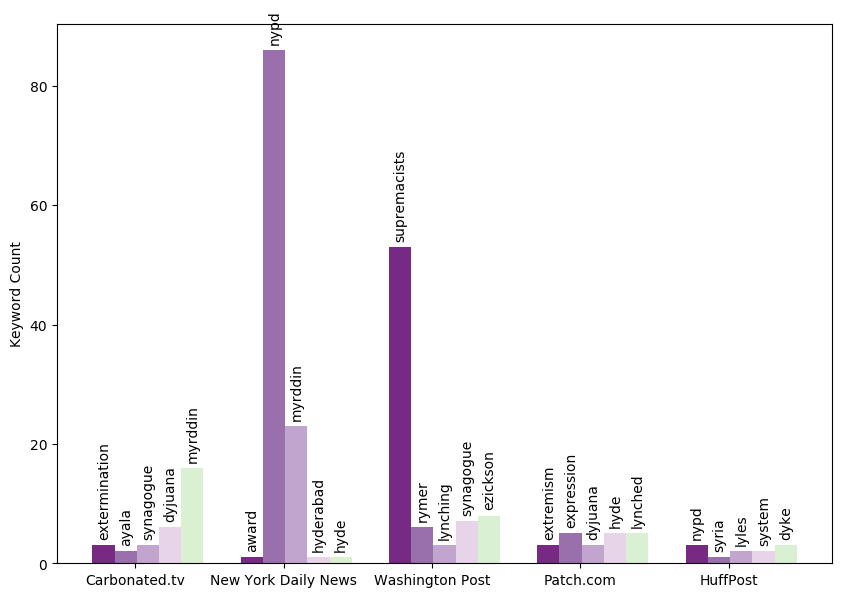

In [51]:
plt.close()

#Find keyword count by news source
keywords_by_source = {}
for source in sources[len(sources) - 5:]: #Only use top five sources
    for article in articles_by_source[source]:
        if not source in keywords_by_source.keys():
            keywords_by_source[source] = {}
        keywords = article['keywords']
        for keyword in keywords:
            if not keyword in keywords_by_source[source].keys():
                keywords_by_source[source][keyword] = 0
            keywords_by_source[source][keyword] += 1
            
#save for later R visualization
with open('source_keyword_paths.csv', 'w') as fout:
    csvout = csv.writer(fout)
    for source in sources[len(sources) - 5:]:
        #Write out number of articles that source contributes
        csvout.writerow([source, len(articles_by_source[source])])
        
        #Get five most common keywords for that source
        most_common_keywords = [k for k,v in list(sorted(
                                                 keywords_by_source[source].items(),
                                                 key = lambda tup: tup[1]
                                               ))[len(keywords_by_source[source]) - 4:]]
        for keyword in most_common_keywords:
            csvout.writerow([source + '-' + keyword, keywords_by_source[source][keyword]])
            
            
            
x = np.arange(5)
keyword_counts = []

colors = ['#762a83','#9970ab','#c2a5cf',
          '#e7d4e8','#d9f0d3']
color_counter = 0

plt.figure(figsize=(10,7))
ax = plt.subplot(111)
biggest_sources = sources[len(sources) - 5:]
spacer = 0.0
for index in range(5):
    source = biggest_sources[index]
    keyword_counter = 0
    filtered_keywords = {k:v for k,v in keywords_by_source[source].items()
                            if not k in REMOVED_KEYWORDS}
    most_common_keywords = list(sorted(
                                filtered_keywords,
                                key = lambda tup: tup[1]
                            ))[len(filtered_keywords) - 5:]
    for keyword in most_common_keywords:
        val = keywords_by_source[source][keyword]
        ax.bar(spacer + x[index] + .3*keyword_counter,
               val,width=0.3,
               color=colors[color_counter],
               align='center')
        ax.text(spacer + x[index] + .3*keyword_counter + .1,
                val + 1,
                keyword,
                ha='right', va='bottom',
                rotation=90)
        keyword_counter += 1
        color_counter +=1
        if color_counter == len(colors):
            color_counter = 0
    spacer += 1
        
    color_counter = 0
plt.xticks([elem*2 + .43 for elem in x], biggest_sources)
plt.ylabel('Keyword Count')
plt.show()